In [131]:
import numpy as np
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import TensorDataset, DataLoader

In [132]:
def h_inner(X, Y):
    return np.dot(X[1:], Y[1:]) - np.dot(X[:1], Y[:1])

def dist(X, Y, K=-1):
    (1 / np.sqrt(-K)) * np.arccosh(-K * h_inner(X, Y))

def parallel_transport(v, nu, mu):
    pass

def expmap(mu, u):
    pass

def invexpmap(mu, z):
    pass

# Linear regression

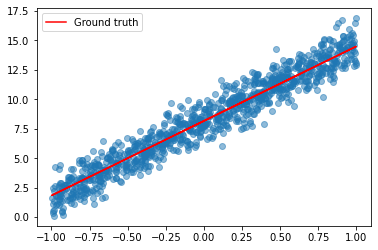

In [163]:
def generate_dataset(n, d):
    X = np.random.uniform(-1, 1, (n, d))
    one = np.ones(n)
    X = np.vstack([one, X.T]).T
    eps = np.random.normal(0, 1, n)
    beta = np.random.uniform(5, 10, d+1)
    Y = (X @ beta) + eps
    return X, Y, beta

d = 1
n = 1000

X, Y, beta_true = generate_dataset(n, d)

if d == 1:
    plt.scatter(X[:, 1:], Y, alpha=0.5)
    plt.plot(X[:, 1:], (X @ beta_true), color='r', label='Ground truth')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


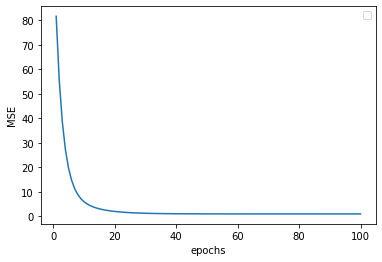

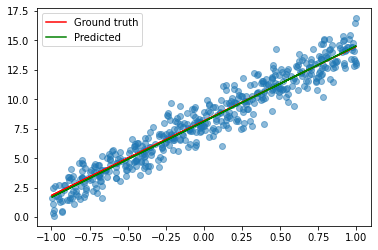

Training loss: 0.9814
held-out loss 0.9463141253642349


In [164]:
def plot(X, Y, beta):
    X = X.detach().numpy()
    Y = Y.detach().numpy()
    beta = beta.detach().numpy()
    plt.scatter(X[:, 1:], Y, alpha=0.5)
    plt.plot(X[:, 1:], (X @ beta_true), color='r', label='Ground truth')
    plt.plot(X[:, 1:], (X @ beta), color='g', label='Predicted')
    plt.legend()
    plt.show()

class LinearRegressor():
    def __init__(self, d):
        self.beta = None

    def fit(self, X, Y, epochs=100, lr=0.1, verbose=False):
        n = X.shape[0]
        d = X.shape[1] - 1
        if self.beta == None:
            self.beta = torch.autograd.Variable(
                torch.zeros(d + 1), requires_grad=True)
        X_pt = torch.Tensor(X)
        Y_pt = torch.Tensor(Y)
        dataset = TensorDataset(X_pt, Y_pt)
        dataloader = DataLoader(dataset, batch_size=n) # GD
        losses = []
        for e in range(epochs):
            for X, Y in dataloader:
                Y_hat = X @ self.beta
                loss = torch.mean((Y - Y_hat) ** 2)
                loss.backward()
                with torch.no_grad():
                    dbeta = self.beta.grad
                    self.beta.add_(dbeta, alpha=-lr)
                self.beta.grad.zero_()
            losses.append(loss.detach().numpy())

        if d == 1 and verbose:
            plt.plot(np.arange(1, epochs+1), losses)
            plt.ylabel('MSE')
            plt.xlabel('epochs')
            plt.legend()
            plt.show()
            plot(X, Y, self.beta)
        print(f'Training loss: {losses[-1]:.4}')

    def predict(self, X):
        X = torch.Tensor(X)
        Y_hat = X @ self.beta
        return Y_hat.detach().numpy()

model = LinearRegressor(d)
model.fit(X[:n//2], Y[:n//2], verbose=True)
Y_hat = model.predict(X[n//2:])
print(f'held-out loss {np.mean((Y_hat - Y[n//2:])**2)}')


# Geodesic regression

In [ ]:
def generate_dataset(n, d):
    X = np.random.uniform(-1, 1, (n, d))
    one = np.ones(n)
    X = np.vstack([one, X.T]).T
    eps = np.random.normal(0, 1, n)
    beta = np.random.uniform(5, 10, d+1)
    Y = (X @ beta) + eps
    return X, Y, beta

d = 1
n = 1000

X, Y, beta_true = generate_dataset(n, d)

if d == 1:
    plt.scatter(X[:, 1:], Y, alpha=0.5)
    plt.plot(X[:, 1:], (X @ beta_true), color='r', label='Ground truth')
    plt.legend()
    plt.show()